#### From the IBL database, get data on weight and trial counts under different water regimes at CSHL
Anne Urai, CSHL, 2019

In [17]:
# PYTHON STARTS BY IMPORTING 'MODULES' AND 'PACKAGES' THAT WE'LL USE LATER

# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context="talk")

# set a path where you want figures to be saved
figpath  = os.path.join(os.path.expanduser('~'), 'Data/Figures_IBL')

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior

If your login to DataJoint was successful, you should see something like 

'Connecting youruser@datajoint.internationalbrainlab.org:3306'

In [9]:
# FIND THE DATA WE NEED
# FIRST, WHICH SUBJECTS ARE DOING THIS CA EXPERIMENT?
subj = (subject.Subject() - subject.Death & 'subject_birth_date < "2018-09-01"').proj('subject_nickname', 'sex') * \
    (subject.SubjectLab() & 'lab_name="churchlandlab"').proj()
print(subj)

*subject_uuid  subject_nickna sex    
+------------+ +------------+ +-----+
1208c089-8b8e- IBL_13         M      
3e97e1d3-2a0f- IBL_34         M      
3f854f88-7879- IBL_11         M      
52a800fc-cbbc- IBL_1          M      
55381f61-4e47- IBL_46         M      
7c751b49-55a6- IBL_10         M      
 (Total: 6)



In [12]:
# get date for each weighing
weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
# create a table with primary key to be the combination of subject_uuid and session_date
# dj.U, U means uniform, all possible combinations of subject uuid and session_date, when
# restricted with weight_with_date, it returns all existing combinations of subject_uuid and 
# session_date in the table weight_with_date
# Note that there are more entries in weight_with_date than in weight_date, indicating there
# exists more than one weighing for some dates.
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date)

# Aggregation to get average weight for each date
# before .aggr is the table you want aggregate, basically you get one value for each entry in 
# weight_with_date
# first argument is the table that is useful to compute the value you need, here weight_with_date
# provides all weights for each date, 'weight' is an attribute in the table weight_with_date
# note that the results have the same number of entries as weight_date
avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)')

# NOW DO THE SAME FOR WATER
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib',
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
# total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
#                                    watertype="CONCAT_WS('; ', watertype_name)")
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')

# get session with date
session_with_date = behavior.TrialSet.proj('n_trials') \
    * (acquisition.Session.proj(session_date='DATE(session_start_time)') & 'session_date > "2019-03-01"')
# Now you can join (*) the two tables avg_weight_date and session_with_date.
# Join * will automatically find matched session_date in both tables, and only show entries where
# these dates exist in both tables. Note there are fewer entries in this resulting table, because
# on some dates weight is missing and other dates session is missing
b = subj * session_with_date * avg_weight_date * total_water_date
b

*subject_uuid  *session_start *session_date  subject_nickna sex     n_trials     avg_weight     total_water    watertype      adlib    
+------------+ +------------+ +------------+ +------------+ +-----+ +----------+ +------------+ +------------+ +------------+ +-------+
1208c089-8b8e- 2019-03-04 15: 2019-03-04     IBL_13         M       479          25.65999984741 1.284000039100 Water 10% Sucr 0        
1208c089-8b8e- 2019-03-05 14: 2019-03-05     IBL_13         M       517          24.81999969482 1.442999958992 Water 10% Sucr 0        
1208c089-8b8e- 2019-03-11 10: 2019-03-11     IBL_13         M       410          25.13999938964 1.082999944686 Water 10% Sucr 0        
1208c089-8b8e- 2019-03-13 14: 2019-03-13     IBL_13         M       465          24.04000091552 1.251000046730 Water 10% Sucr 0        
1208c089-8b8e- 2019-03-14 15: 2019-03-14     IBL_13         M       719          23.61000061035 1.934999942779 Water 10% Sucr 0        
1208c089-8b8e- 2019-03-15 09: 2019-03-15     IBL_13         M       499          24.03000068664 1.338000059127 Water 10% Sucr 1        
1208c089-8b8e- 2019-03-18 15: 2019-03-18     IBL_13         M       600          24.68000030517 1.544999957084 Water 10% Sucr 0        
1208c089-8b8e- 2019-03-19 13: 2019-03-19     IBL_13         M       569          24.30999946594 1.485000014305 Water 10% Sucr 0        
1208c089-8b8e- 2019-03-20 13: 2019-03-20     IBL_13         M       633          23.79999923706 1.697999954223 Water 10% Sucr 0        
1208c089-8b8e- 2019-03-21 14: 2019-03-21     IBL_13         M       307          23.70999908447 0.753000020980 Water 10% Sucr 0        
1208c089-8b8e- 2019-03-22 13: 2019-03-22     IBL_13         M       722          23.15999984741 2.013000011444 Water 10% Sucr 1        
1208c089-8b8e- 2019-03-25 14: 2019-03-25     IBL_13         M       614          23.69000053405 1.667999982833 Water 10% Sucr 0        
   ...
 (Total: 249)

In [19]:
df = pd.DataFrame(b.fetch(as_dict=True))
df.head(n=20)

adlib  avg_weight  n_trials session_date  session_start_time sex  \
0       0   25.660000       479   2019-03-04 2019-03-04 15:33:34   M   
1       0   24.820000       517   2019-03-05 2019-03-05 14:43:03   M   
2       0   25.139999       410   2019-03-11 2019-03-11 10:39:55   M   
3       0   24.040001       465   2019-03-13 2019-03-13 14:48:37   M   
4       0   23.610001       719   2019-03-14 2019-03-14 15:20:18   M   
5       1   24.030001       499   2019-03-15 2019-03-15 09:31:11   M   
6       0   24.680000       600   2019-03-18 2019-03-18 15:02:59   M   
7       0   24.309999       569   2019-03-19 2019-03-19 13:46:46   M   
8       0   23.799999       633   2019-03-20 2019-03-20 13:24:10   M   
9       0   23.709999       307   2019-03-21 2019-03-21 14:00:50   M   
10      1   23.160000       722   2019-03-22 2019-03-22 13:01:28   M   
11      0   23.690001       614   2019-03-25 2019-03-25 14:19:43   M   
12      0   23.840000       665   2019-03-26 2019-03-26 12:23:37   M   
13      0   23.440001       494   2019-03-27 2019-03-27 12:03:11   M   
14      0   23.059999       804   2019-03-28 2019-03-28 12:00:40   M   
15      1   22.980000       613   2019-03-29 2019-03-29 14:42:41   M   
16      0   24.340000       533   2019-04-01 2019-04-01 11:27:41   M   
17      0   23.969999       406   2019-04-02 2019-04-02 10:20:59   M   
18      0   23.459999       610   2019-04-03 2019-04-03 10:59:31   M   
19      0   23.260000       600   2019-04-04 2019-04-04 11:26:28   M   

   subject_nickname                          subject_uuid  total_water  \
0            IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.284   
1            IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.443   
2            IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.083   
3            IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.251   
4            IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.935   
5            IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.338   
6            IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.545   
7            IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.485   
8            IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.698   
9            IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        0.753   
10           IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        2.013   
11           IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.668   
12           IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.698   
13           IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.305   
14           IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        2.088   
15           IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.656   
16           IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.410   
17           IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.065   
18           IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.446   
19           IBL_13  1208c089-8b8e-4a87-98f0-05a68fb18370        1.419   

                                  watertype  
0                         Water 10% Sucrose  
1                         Water 10% Sucrose  
2                         Water 10% Sucrose  
3                         Water 10% Sucrose  
4                         Water 10% Sucrose  
5   Water 10% Sucrose; Water 2% Citric Acid  
6                         Water 10% Sucrose  
7                         Water 10% Sucrose  
8                         Water 10% Sucrose  
9                         Water 10% Sucrose  
10  Water 10% Sucrose; Water 2% Citric Acid  
11                        Water 10% Sucrose  
12                        Water 10% Sucrose  
13                        Water 10% Sucrose  
14                        Water 10% Sucrose  
15  Water 10% Sucrose; Water 2% Citric Acid  
16                        Water 10% Sucrose  
17                        Water 10% Sucrose  
18                        Water 10% Sucrose  
19              

[Text(0, 0.5, 'Number of trials'), Text(0.5, 0, 'Days')]

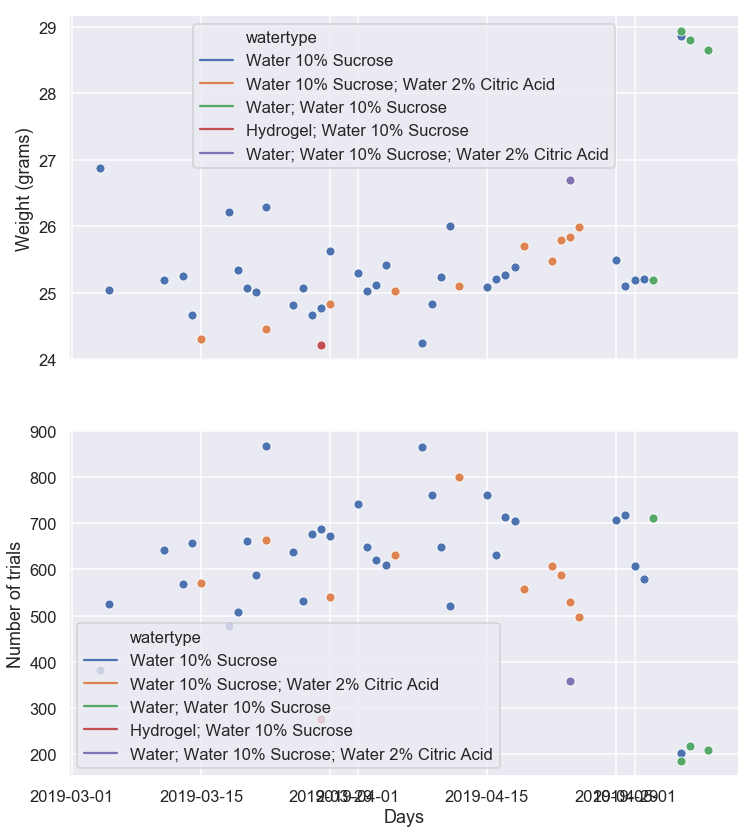

In [18]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(2,1, sharex=True, figsize=(12, 14))
sns.lineplot(x="session_date", y="avg_weight", hue="watertype", marker='o', linewidth=0, ci=None, data=df, ax=ax[0])
ax[0].set(ylabel="Weight (grams)", xlabel="Days")
sns.lineplot(x="session_date", y="n_trials", hue="watertype", marker='o',  linewidth=0, ci=None, data=df, ax=ax[1])
ax[1].set(ylabel="Number of trials", xlabel="Days")

Now that we have our data, let's visualize it!

The plot above shows an example of using seaborn (https://seaborn.pydata.org/index.html), see the documentation for many other types of plots you can make. 

Try to make this plot a bit nicer, by doing the following:
1. move the legend to the right of the plot, or make it smaller so it doesn't obscure the datapoints. you can also rotate the 'tickmarks' (dates) on the x-axis to make them more readable.
- make an additional column with the day of the week

2. play with the arguments to 'lineplot' - see e.g. what happens when linewidth=1, or ci=95
3. instead of marking each day by its water condition _that day_, change the dataframe to label it with the condition of _that week_ (so that e.g. a week with only 10% sucrose water, but _preceded_ by a 2% CA weekend is different from a week with 10% sucrose water, but _preceded by a regular water weekend). this should then indicate the color
4. check in Alyx that all mice on a given day have the same 'condition'. Also make sure there are data logged for each day, including the weekend.
4. repeat the plot for individual mice (hint: seaborn's FacetGrid)


Of these, 3 and 4 are the most important: the rest is 

Once this looks good, try to create a new plot that ignores the date, and plots all datapoints (weight and nr of trials) from one condition (weekend + week water regime) in one overview - as on the SfN poster. You can use e.g. seaborn's catplot to make it look nice.

Other todo (for Anne):
1. indicate Mondays 


In [20]:
df['watertype'].unique()

array(['Water 10% Sucrose', 'Water 10% Sucrose; Water 2% Citric Acid',
       'Water; Water 10% Sucrose', 'Hydrogel; Water 10% Sucrose',
       'Water; Water 10% Sucrose; Water 2% Citric Acid'], dtype=object)